In the folowing notebook I will evaluate some of the more popular calssifiers, while doing a grid search with cross validation to find good meta parameters. I will then run a broader grid search on the best classifier.

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ScalerAndOneHotEncoder import ScalerAndOneHotEncoder
from sklearn.preprocessing import StandardScaler
from Filter_extreme_earns import filter_extreme_earns
from sklearn.preprocessing import RobustScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading the data

In [6]:
df = pd.read_csv(
    'Data/income_data_2017_clean_zeros.csv.bz2',
    compression='bz2',
    index_col='peridnum')

Defining the numerical and categorical variables

In [7]:
categorical_features = [
    'PEIOOCC', 'A_HGA', 'PRDTRACE', 'FKIND', 'A_CLSWKR', 'A_WKSTAT', 'A_MJIND',
    'MJOCC', 'PTYN', 'LJCW', 'A_SEX', 'WEMOCG', 'MIG_CBST', 'MIGSAME',
    'H_TYPE', 'H_LIVQRT', 'GTCBSA', 'GESTFIPS'
]
numerical_features = [
    'H_NUMPER', 'FPERSONS', 'FOWNU6', 'FOWNU18', 'A_AGE', 'A_HRS1', 'A_USLHRS',
    'PHMEMPRS', 'HRSWK', 'HNUMFAM'
]
labels = ['ERN_VAL']
features = categorical_features + numerical_features

Filtering out people who earn more then 250k per year or less then 7K per year and people making more then 3$\sigma$ than the mean for their occupation

In [8]:
df_filt = df[(df['ern_val'] > 3000) & (df['ern_val'] < 250000)]
df_filt = filter_extreme_earns(df_filt, 3)
# converting colum names to uppercase
df_filt.columns = df_filt.columns.str.upper()

df_filt = df_filt[features + labels]

# Getting the index of categorical variables for the OneHot encoder.
categorical_index = [
    i for i, x in enumerate(df_filt.columns.values)
    if x in categorical_features
]

Preparing the pipeline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [10]:
# getting features
X = df_filt[features].values
# Setting a binary tager from the ern_val column
y = (df_filt.ERN_VAL > 40000).values
# Spliting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

#defining RobustScaler for the nuerical and onehot for categorical features to be used in the pipeline
scaler_encoder = ScalerAndOneHotEncoder(
    RobustScaler(), categorical_index=categorical_index)



Starting with Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

steps = [('scaler_encoder', scaler_encoder),
        ('logistic', LogisticRegression() )]
pipeline = Pipeline(steps)

Definig search paramerts and running grid search

In [12]:
from sklearn.model_selection import GridSearchCV
# Meta parameters
cs = np.logspace(-2, 2, 40)
penalty = ['l2', 'l1']
class_weight = [None, 'balanced']

logistic_estimator = GridSearchCV(pipeline,
                         dict(
                             logistic__C=cs,
                             logistic__penalty=penalty,
                             logistic__class_weight=class_weight),
                        cv=5,
                        scoring='f1',
                        n_jobs=20)

In [13]:
logistic_estimator.fit(X_train, y_train)
print (logistic_estimator.best_score_) 
print (logistic_estimator.best_params_)

0.726430647499431
{'logistic__C': 0.17012542798525893, 'logistic__class_weight': 'balanced', 'logistic__penalty': 'l2'}


In [14]:
import sklearn.metrics as met
y_pred = logistic_estimator.predict(X_test)
print(met.confusion_matrix(y_test,y_pred, labels=[0,1]))
print(met.f1_score(y_test,y_pred))

[[11658  3230]
 [ 1394  6348]]
0.733025404157044


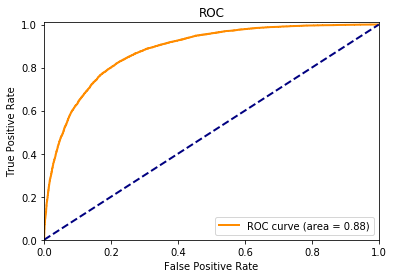

In [15]:
from plotting_funcs import plot_roc
plot_roc(logistic_estimator, X_test, y_test)
_= plt.show()

### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
#Preparing the pipeline
steps = [('scaler_encoder', scaler_encoder),
        ('rf', RandomForestClassifier(n_jobs=20) )]
pipeline = Pipeline(steps)

Defining the search grid

In [ ]:
# Meta parameters
n_estimators = [100, 200, 300, 400]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
max_depth = [None, 3, 5]
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 3]

rf_estimator = GridSearchCV(pipeline,
                         dict(
                             rf__n_estimators=n_estimators,
                             rf__criterion=criterion,
                             rf__max_features=max_features,
                             rf__min_samples_leaf=min_samples_leaf,
                             rf__min_samples_split=min_samples_split),
                        cv=5,
                        scoring='f1',
                        verbose=0)

In [ ]:
rf_estimator.fit(X_train, y_train)

In [ ]:
print (rf_estimator.best_score_) 
print (rf_estimator.best_params_)
y_pred = rf_estimator.predict(X_test)
print(met.confusion_matrix(y_test,y_pred, labels=[0,1]))
print(met.f1_score(y_test,y_pred))
plot_roc(rf_estimator, X_test, y_test)
_= plt.show()

### SVM Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
#Preparing the pipeline
steps = [('scaler_encoder', scaler_encoder),
        ('svc', SVC() )]
pipeline = Pipeline(steps)

In [ ]:
# Meta parameters
C = [0.1, 1, 5, 10, 30]
gamma =  ['auto', 1e-2, 1e-3]


svc_estimator = GridSearchCV(pipeline,
                         dict(
                             svc__C=C,
                             svc__gamma=gamma
                             ),
                        cv=5,
                        scoring='f1',
                        verbose=0,
                        n_jobs=20)

In [ ]:
svc_estimator.fit(X_train, y_train)

In [ ]:
print (rf_estimator.best_score_) 
print (rf_estimator.best_params_)
y_pred = rf_estimator.predict(X_test)
print(met.confusion_matrix(y_test,y_pred, labels=[0,1]))
print(met.f1_score(y_test,y_pred))
plot_roc(rf_estimator, X_test, y_test)
_= plt.show()

In [ ]:
best_params = {'Logistic Regression': 
               {'Parameters': logistic_estimator.best_params_ ,
                'Best Score': logistic_estimator.best_score_},
              'Random Forest': 
               {'Parameters': rf_estimator.best_params_ ,
                'Best Score': rf_estimator.best_score_},
              'SVM Classifier':
              {'Parameters': svc_estimator.best_params_ ,
                'Best Score': svc_estimator.best_score_}
              }

In [ ]:
import pickle
pickle.dump( best_params, open( 'best_params_Log_Forest_SVM.p', 'wb' ) )